<a href="https://colab.research.google.com/github/AbdelRayan/SleepSlopeProject/blob/main/SleepSlopes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
!pip install fooof

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install neurodsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
# NeuroDSP
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
# FOOOF
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
# Other
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Loading HPC and PFC LFP data from MAT files stored in Google Drive.
hpc_data = loadmat('/content/drive/My Drive/Donders/HPC_100_CH18_0.continuous.mat')
hpc_data = hpc_data['HPC']
pfc_data = loadmat('/content/drive/My Drive/Donders/PFC_100_CH22_0.continuous.mat')
pfc_data = pfc_data['PFC']

In [ ]:
# Loading sleep scoring data from MAT files stored in Google Drive.
sleep_scoring = loadmat('/content/drive/My Drive/Donders/2021-06-03_13-34-04_posttrial5-states_ES2.mat')
sleep_scoring = sleep_scoring['states']

# Extracting Power Spectrum & Fractal components for HPC (First hour)

In [ ]:
def normalizer(x):
    # Normalize input data using Z-score, handling NaN values
    return (x - np.nanmean(x)) / (np.nanstd(x))

lfp_normalized = normalizer(hpc_data)  # Apply Z-score normalization to HPC data

In [ ]:
sig = lfp_normalized
sig = np.ravel(sig) # Flattening the data
fs = 2500 # Sampling Frequency

In [ ]:
# using neurodsp
# Extraxting Power Spectrum for the first 3-sec of data
nperseg = min(2500, len(sig))
freq_mean, psd_mean = compute_spectrum(sig[:7500], fs, method='welch', nperseg=nperseg)

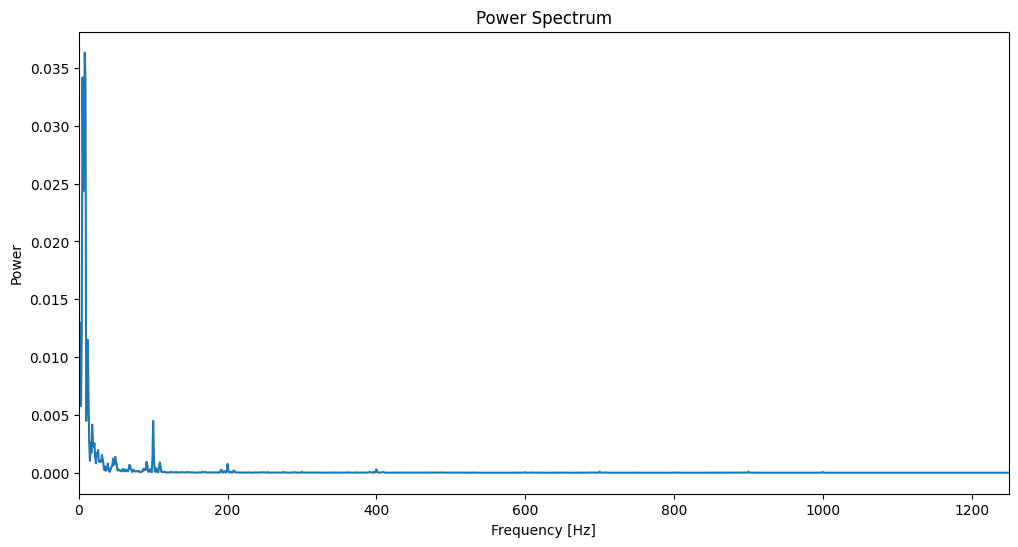

In [ ]:
# Plotting Power spectrum
plt.figure(figsize=(12, 6))
plt.plot(freq_mean, psd_mean)
plt.title('Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.xlim(0, fs/2)
plt.show()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



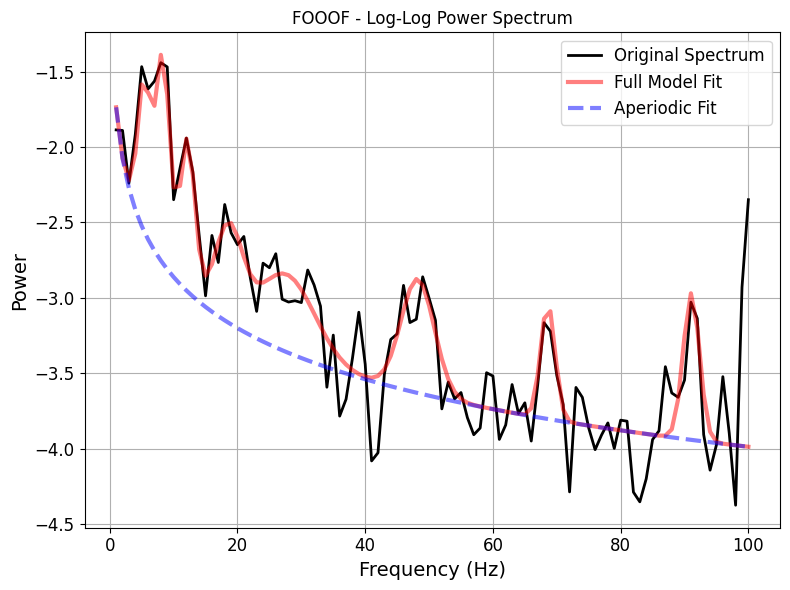

In [ ]:
# Initialize and train FOOOF model on extracted PSD data
fm = FOOOF()
fm.fit(freq_mean, psd_mean, freq_range=[1, 100])  # freq_range can be modified as needed

# Plotting the FOOOF power spectrum
fig, ax = plt.subplots(figsize=(8, 6))
fm.plot(ax=ax)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FOOOF - Log-Log Power Spectrum')
plt.show()


In [ ]:
# Extracting the first 60 minutes of HPC data and segmenting it into 3-second windows.
# For each window, compute the Power Spectrum Density (PSD) using the Welch method.
# Then, fit the FOOOF model on the PSD data to extract aperiodic parameters.
data_HPC = sig
data_HPC_60_min = data_HPC[:60*60*fs]
window_length = 3 * fs
aperiodic_params_HPC = []
freq_range = [1, 100]

for start in range(0, len(data_HPC_60_min) - window_length + 1, window_length):
    window = data_HPC_60_min[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_HPC.append(fm.get_params('aperiodic_params'))

9000000


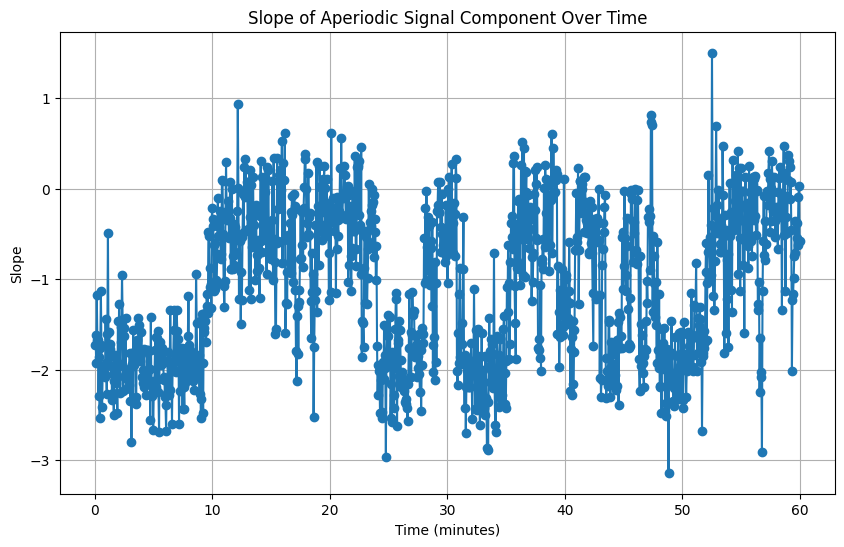

In [ ]:
# Extracting and plotting the slopes of the aperiodic signal component from HPC data over time.
# 'slopes_HPC' contains the slopes from 'aperiodic_params_HPC'.
# Time is converted to minutes for ease of interpretation.
slopes_HPC = [param[0] for param in aperiodic_params_HPC]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_HPC), 3)
time_minutes = time / 60

plt.figure(figsize=(10, 6))
plt.plot(time_minutes, slopes_HPC, marker='o', linestyle='-')
plt.title("Slope of Aperiodic Signal Component Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
# Normalizing the slope data using Z-score normalization and then smoothing it.
# 'savgol_filter' is applied for smoothing with a window length of 101 and a polynomial order of 5.
slopes_normalized_HPC = zscore(slopes)
slopes_smoothed_HPC = savgol_filter(slopes_normalized_HPC, window_length=101, polyorder=5)

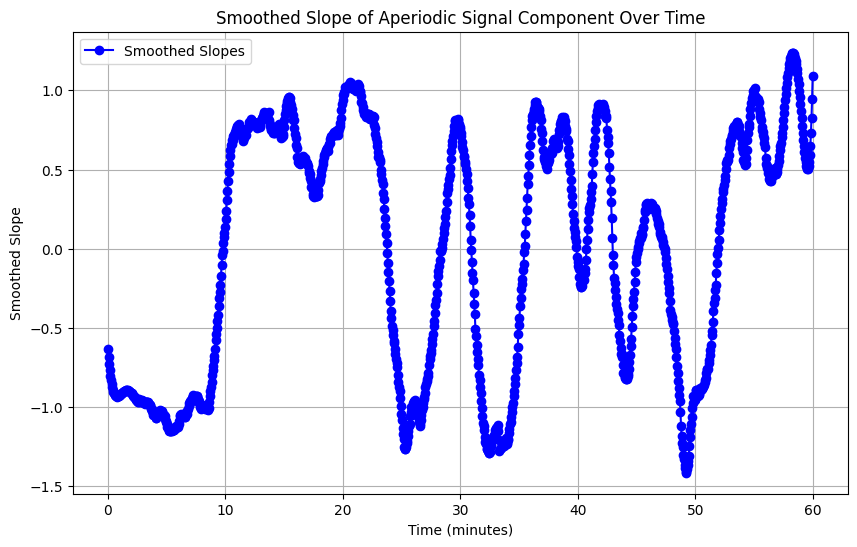

In [ ]:
# Plotting Smoothed Slopes
plt.figure(figsize=(10, 6))
plt.plot(time_minutes, slopes_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()
plt.show()

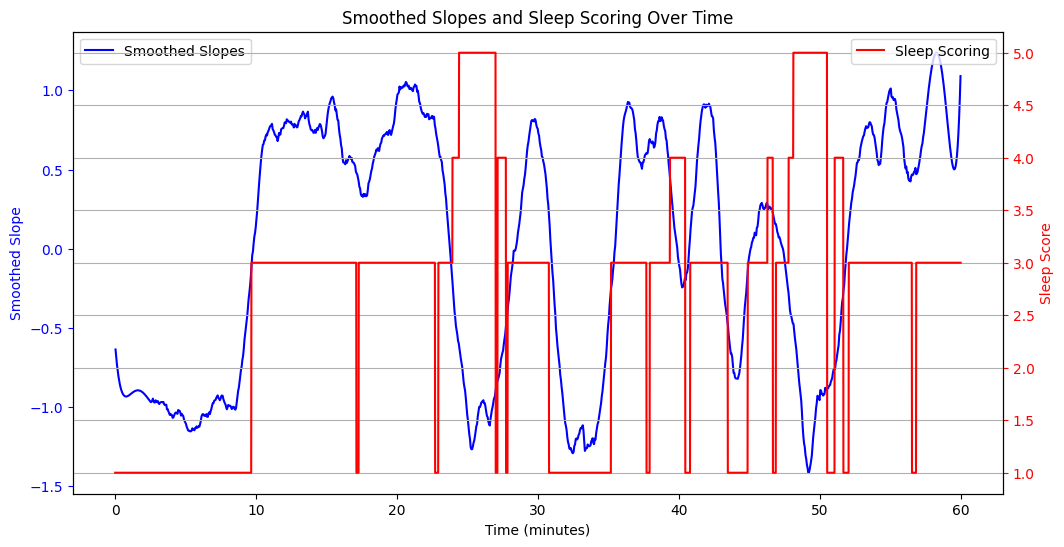

In [ ]:
# Plotting smoothed slopes and sleep scoring data together for comparison.

time_minutes_sleep = np.arange(0, 60, 1/60)

sleep_scoring_1hr = sleep_scoring[0, :3600]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time_minutes, slopes_smoothed_HPC, 'b-', label='Smoothed Slopes')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Smoothed Slope', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(time_minutes_sleep, sleep_scoring_1hr, 'r-', label='Sleep Scoring')
ax2.set_ylabel('Sleep Score', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title("Smoothed Slopes and Sleep Scoring Over Time")
plt.grid(True)
plt.show()

# Training SVM to predict sleep stages

In [ ]:
window_size = 3
sleep_scoring_reshaped = []

sleep_scoring_first_hour = sleep_scoring[0, :3600]

for i in range(0, len(sleep_scoring_first_hour), window_size): # Using majority voting to reshaping sleep scoring variable
    window = sleep_scoring_first_hour[i:i + window_size]
    majority_state = mode(window, axis=None)[0]
    sleep_scoring_reshaped.append(majority_state)

sleep_scoring_reshaped = np.array(sleep_scoring_reshaped)

assert len(sleep_scoring_reshaped) == len(slopes_smoothed) # Just checking for any size incompatibility

if slopes_smoothed.ndim == 1:
    slopes_smoothed = slopes_smoothed.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(slopes_smoothed, sleep_scoring_reshaped, test_size=0.3, random_state=0) # Training svm 30% test

y_train = y_train.ravel()
y_test = y_test.ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7805555555555556
Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.80      0.70       107
           3       0.87      0.99      0.93       197
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        33

    accuracy                           0.78       360
   macro avg       0.38      0.45      0.41       360
weighted avg       0.67      0.78      0.72       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Over sampling the data

In [ ]:
window_size = 3
sleep_scoring_reshaped = []

sleep_scoring_first_hour = sleep_scoring[0, :3600]

for i in range(0, len(sleep_scoring_first_hour), window_size):
    window = sleep_scoring_first_hour[i:i + window_size]
    majority_state = mode(window, axis=None)[0]
    sleep_scoring_reshaped.append(majority_state)

sleep_scoring_reshaped = np.array(sleep_scoring_reshaped)

assert len(sleep_scoring_reshaped) == len(slopes_smoothed)

if slopes_smoothed.ndim == 1:
    slopes_smoothed = slopes_smoothed.reshape(-1, 1)


X_train, X_test, y_train, y_test = train_test_split(slopes_smoothed, sleep_scoring_reshaped, test_size=0.3, random_state=0)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(X_train_scaled, y_train_resampled)

y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.5888888888888889
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       107
           3       0.96      0.82      0.88       197
           4       0.24      0.91      0.38        23
           5       0.29      0.91      0.44        33

    accuracy                           0.59       360
   macro avg       0.37      0.66      0.42       360
weighted avg       0.57      0.59      0.55       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Under sampling the data

In [ ]:
window_size = 3
sleep_scoring_reshaped = []

sleep_scoring_first_hour = sleep_scoring[0, :3600]

for i in range(0, len(sleep_scoring_first_hour), window_size):
    window = sleep_scoring_first_hour[i:i + window_size]
    majority_state = mode(window, axis=None)[0]
    sleep_scoring_reshaped.append(majority_state)

sleep_scoring_reshaped = np.array(sleep_scoring_reshaped)

assert len(sleep_scoring_reshaped) == len(slopes_smoothed)

if slopes_smoothed.ndim == 1:
    slopes_smoothed = slopes_smoothed.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(slopes_smoothed, sleep_scoring_reshaped, test_size=0.3, random_state=0)

rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(X_train_scaled, y_train_resampled)

y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.6055555555555555
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       107
           3       0.95      0.85      0.90       197
           4       0.25      0.87      0.39        23
           5       0.29      0.91      0.43        33

    accuracy                           0.61       360
   macro avg       0.37      0.66      0.43       360
weighted avg       0.56      0.61      0.56       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Extracting Power Spectrum & Fractal components for PFC (First hour)

In [ ]:
pfc_normalized = normalizer(pfc_data)

In [ ]:
# Extracting slopes of Aperiodic Signal Component Over Time
data_pfc = pfc_normalized
fs = 2500

data_60_min = data_pfc[:60*60*fs]
window_length = 3 * fs
aperiodic_params_pfc = []
freq_range = [1, 100]
for start in range(0, len(data_60_min) - window_length + 1, window_length):
    window = data_60_min[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_pfc.append(fm.get_params('aperiodic_params'))


9000000


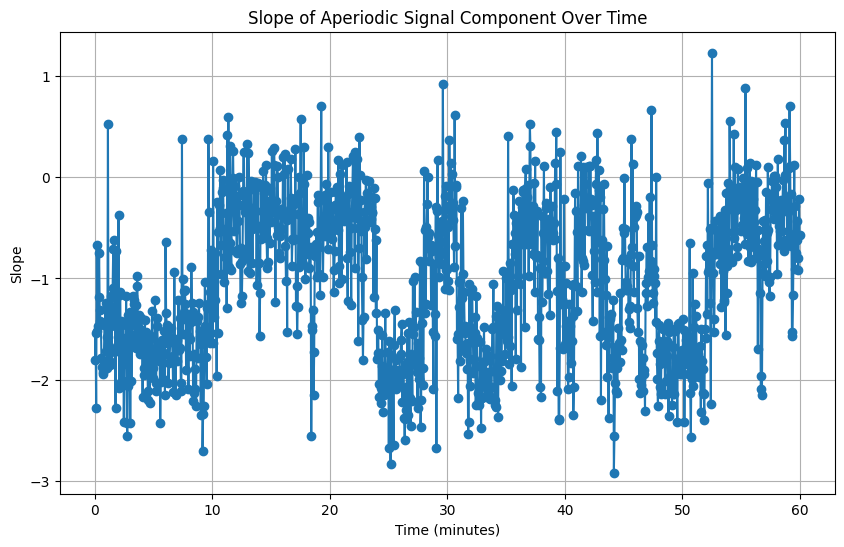

In [ ]:
slopes_pfc = [param[0] for param in aperiodic_params_pfc]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_pfc), 3)

time_minutes = time / 60

plt.figure(figsize=(10, 6))
plt.plot(time_minutes, slopes_pfc, marker='o', linestyle='-')
plt.title("Slope of Aperiodic Signal Component Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()


In [ ]:
# Normalizing and smoothing the data
slopes_normalized_pfc = zscore(slopes)
slopes_smoothed_pfc = savgol_filter(slopes_normalized_pfc, window_length=101, polyorder=4)

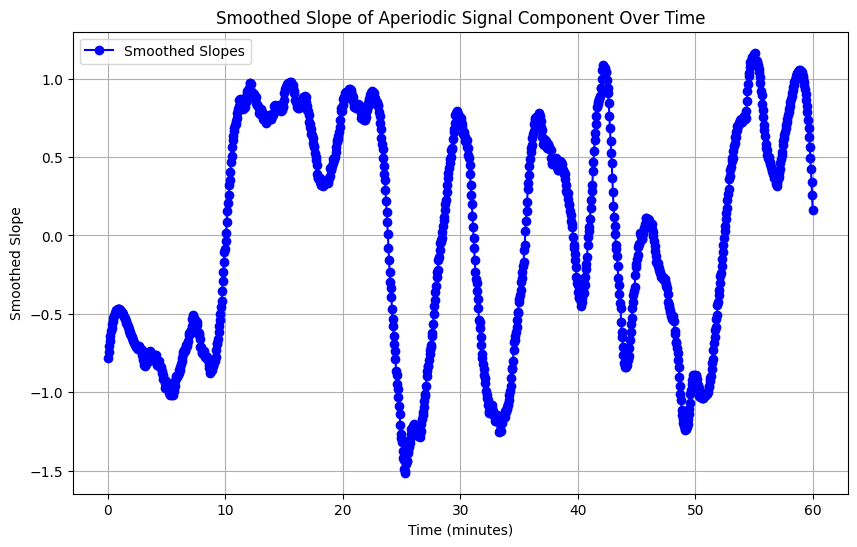

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_minutes, slopes_smoothed_pfc, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()
plt.show()

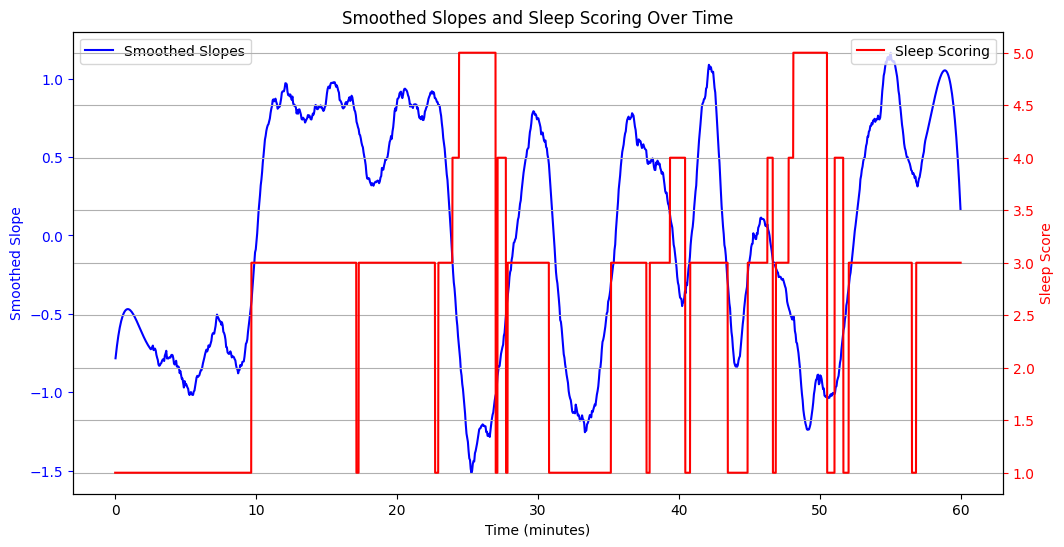

In [ ]:
time_minutes_sleep = np.arange(0, 60, 1/60)

sleep_scoring_1hr = sleep_scoring[0, :3600]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time_minutes, slopes_smoothed_pfc, 'b-', label='Smoothed Slopes')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Smoothed Slope', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(time_minutes_sleep, sleep_scoring_1hr, 'r-', label='Sleep Scoring')
ax2.set_ylabel('Sleep Score', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title("Smoothed Slopes and Sleep Scoring Over Time")
plt.grid(True)
plt.show()


# Analyzing the full 3 hours of the data

## HPC

In [ ]:
# Extracting the full 3 hours of HPC data and segmenting it into 3-second windows.

data_HPC = sig
window_length = 3 * fs
aperiodic_params_HPC = []
freq_range = [1, 100]
for start in range(0, len(data_HPC) - window_length + 1, window_length):
    window = data_HPC[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_HPC.append(fm.get_params('aperiodic_params'))

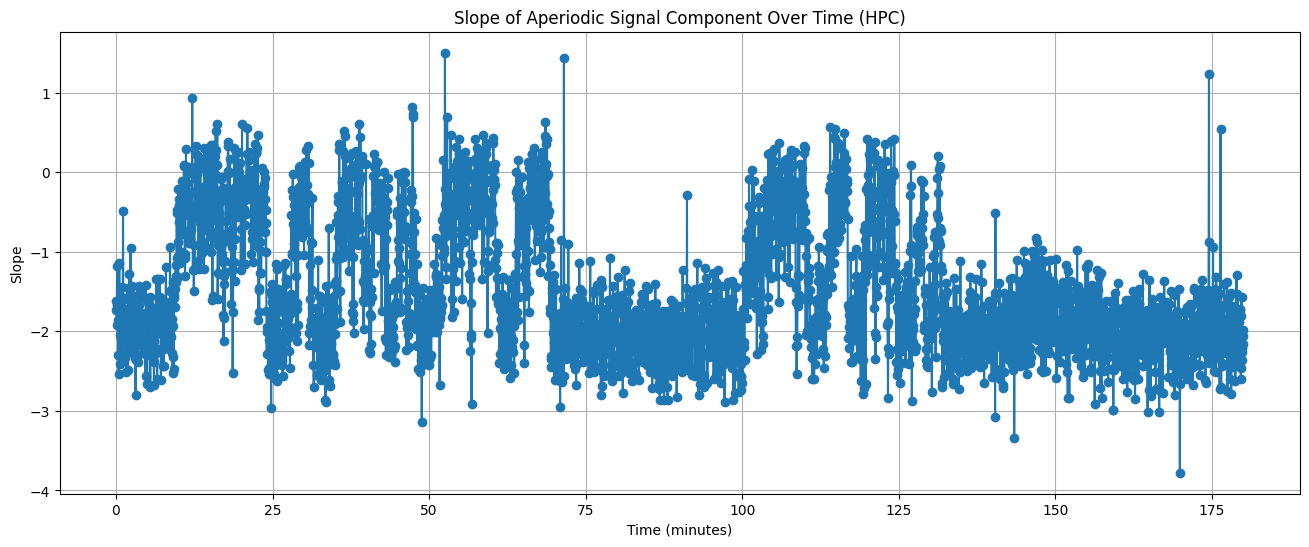

In [ ]:
# Extracting slopes of Aperiodic Signal Component Over Time
slopes_HPC = [param[0] for param in aperiodic_params_HPC]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_HPC), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_HPC, marker='o', linestyle='-')
plt.title("Slope of Aperiodic Signal Component Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

In [ ]:
# Normalizing and smoothing the data
slopes_normalized_HPC = zscore(slopes_HPC)
slopes_smoothed_HPC = savgol_filter(slopes_normalized_HPC, window_length=101, polyorder=4)

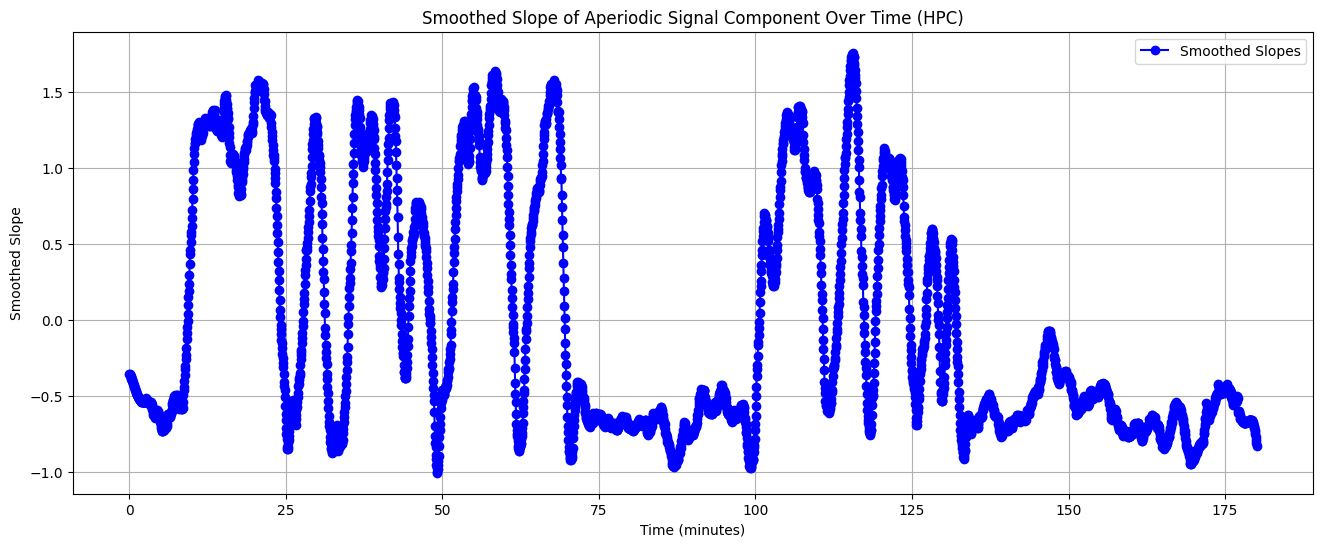

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()
plt.show()

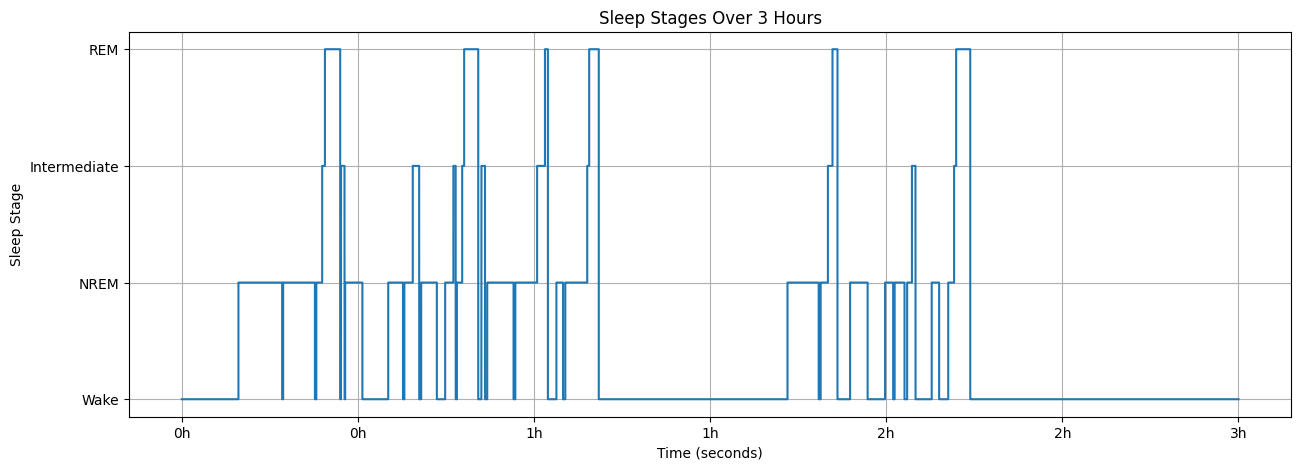

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
labeled_scores = [score_labels[score] for score in sleep_scoring[0, :]]

time_seconds = np.arange(0, len(sleep_scoring[0, :]))  # Assuming one score per second

plt.figure(figsize=(15, 5))  # Wider plot for better visibility
plt.step(time_seconds, labeled_scores, where='mid')  # Using a step plot
plt.xlabel('Time (seconds)')
plt.ylabel('Sleep Stage')
plt.title('Sleep Stages Over 3 Hours')
plt.yticks(list(score_labels.values()))  # Set y-ticks to the stage labels
plt.xticks(np.arange(0, 10801, 1800), [f"{int(x/3600)}h" for x in np.arange(0, 10801, 1800)])  # Marking each half hour
plt.grid(True)
plt.show()

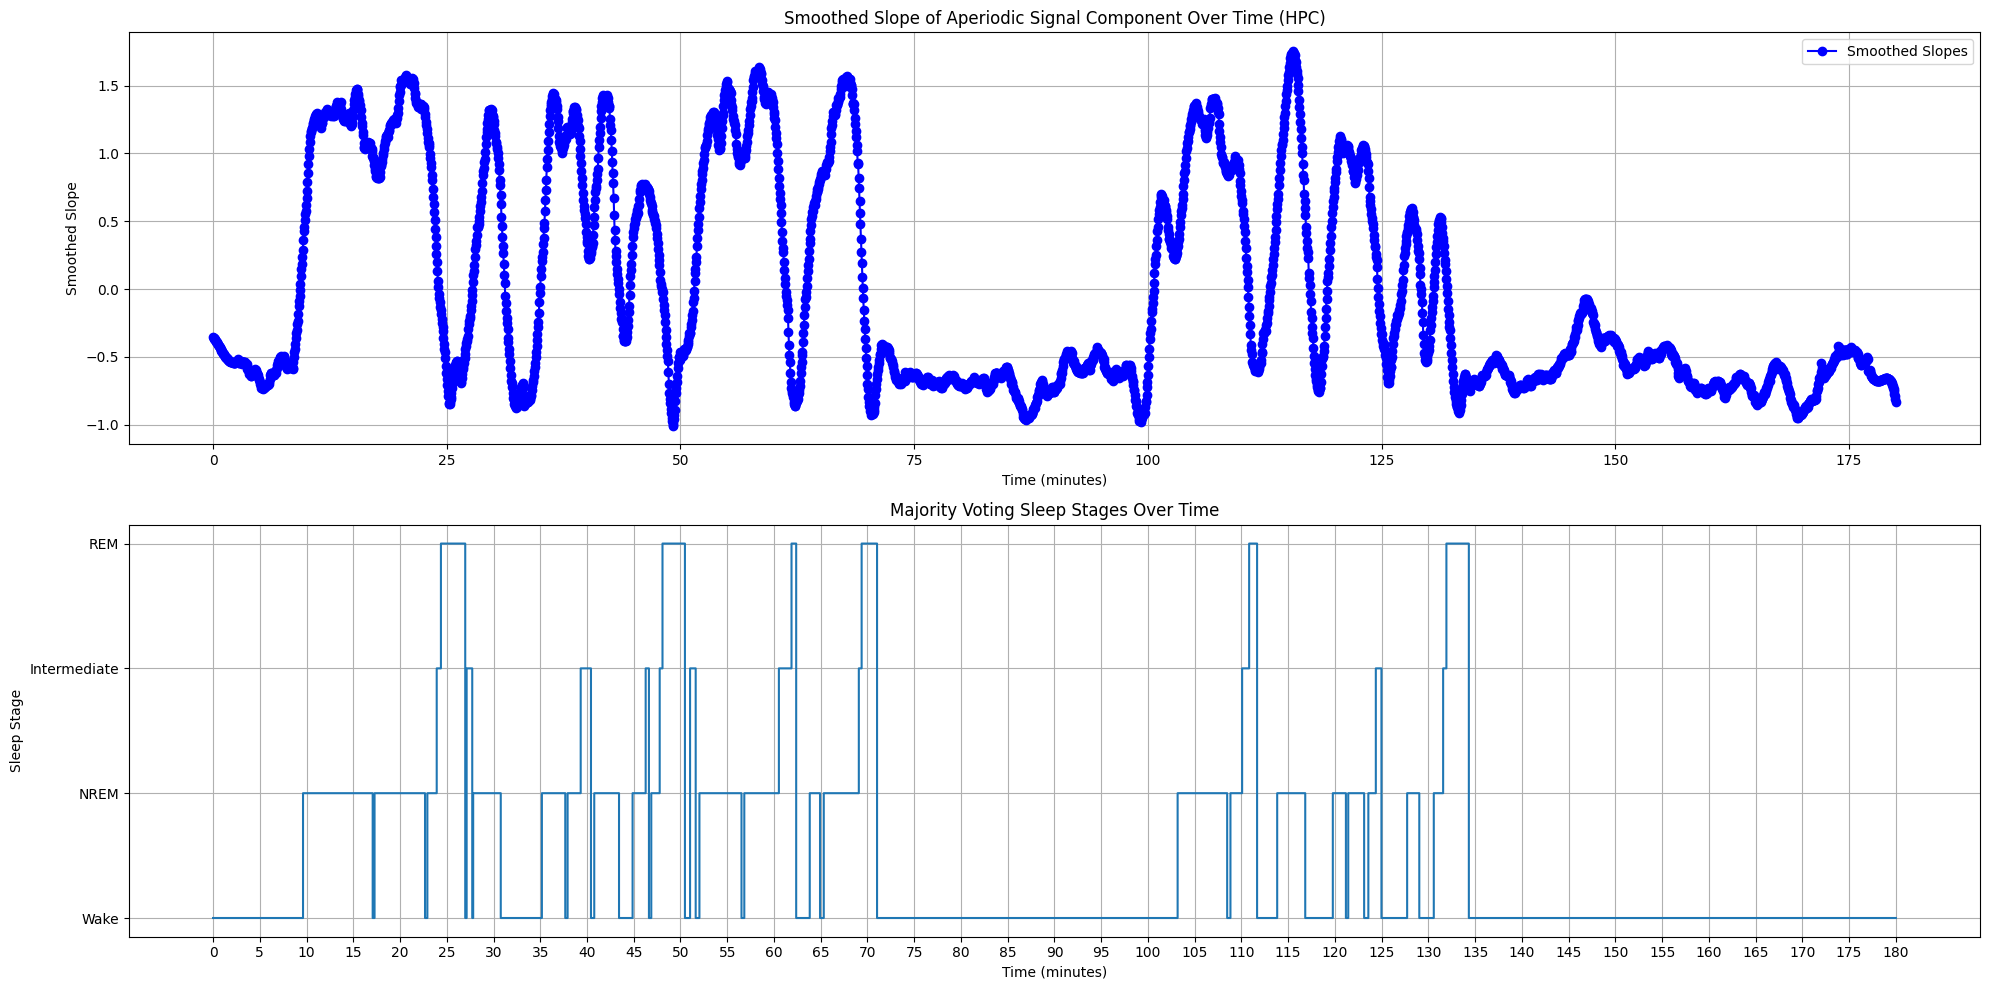

In [ ]:
# Score labels and their numerical mapping
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

# Reshape and apply majority voting
reshaped_scores = sleep_scoring.reshape(-1, 3)
majority_scores = mode(reshaped_scores, axis=1).mode.flatten()

# Ensure all scores in majority_scores are in score_labels
assert all(score in score_labels for score in majority_scores), "Some scores are not in score_labels"

# Map categorical labels to numerical values for plotting
mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])

# Time arrays for x-axis in minutes
time_minutes = np.arange(0, len(slopes_smoothed_HPC)) * 3 / 60  # Convert to minutes
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60  # Convert to minutes

plt.figure(figsize=(20, 10))

# First subplot - Smoothed Slopes
plt.subplot(2, 1, 1)
plt.plot(time_minutes, slopes_smoothed_HPC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (HPC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()

# Second subplot - Sleep Scoring
plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))  # Setting y-ticks to stage labels
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))  # Marking every 5 minutes
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


# PFC

In [ ]:
def normalizer(x):
    return (x - np.nanmean(x)) / (np.nanstd(x))

lfp_normalized_pfc = normalizer(pfc_data)

In [ ]:
sig_pfc = lfp_normalized_pfc
sig_pfc = np.ravel(sig_pfc) # Flattening Data

In [ ]:
# Extracting the full 3 hours of PFC data and segmenting it into 3-second windows.

data_PFC = sig_pfc
window_length = 3 * fs
aperiodic_params_PFC = []
freq_range = [1, 100]
for start in range(0, len(data_PFC) - window_length + 1, window_length):
    window = data_PFC[start:start + window_length]
    window = np.ravel(window)
    freq_mean, psd_mean = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq_mean, psd_mean, freq_range)
    aperiodic_params_PFC.append(fm.get_params('aperiodic_params'))


In [ ]:
slopes_PFC = [param[0] for param in aperiodic_params_PFC]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_PFC), 3)

In [ ]:
# Normalizing and smoothing the data
slopes_normalized_PFC = zscore(slopes_PFC)
slopes_smoothed_PFC = savgol_filter(slopes_normalized_PFC, window_length=101, polyorder=4)

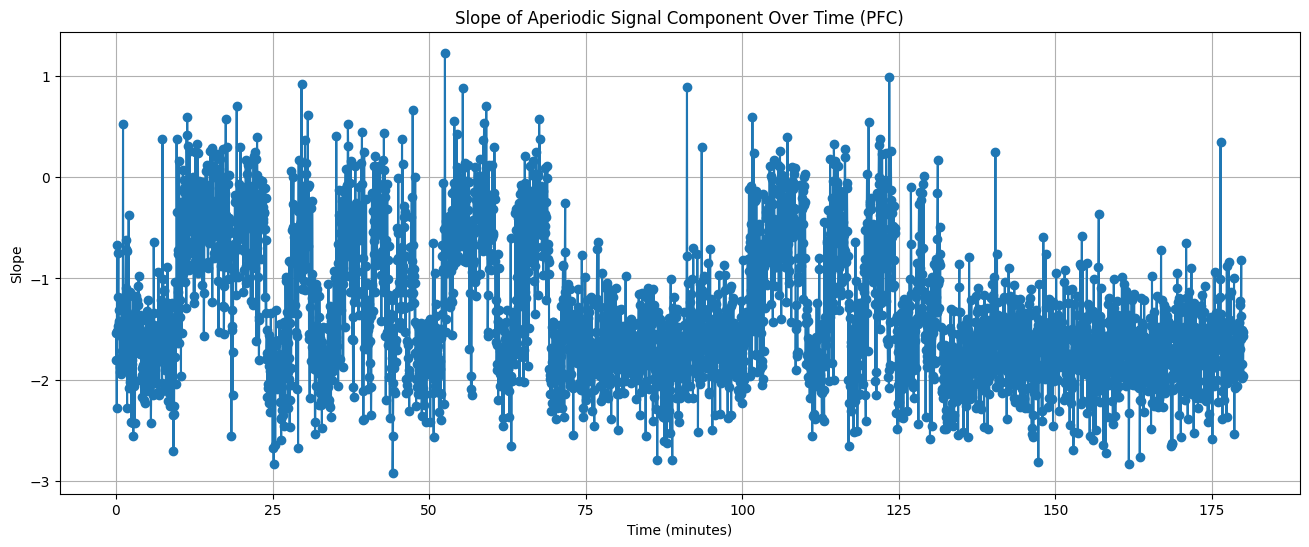

In [ ]:
# Extracting slopes of Aperiodic Signal Component Over Time
slopes_PFC = [param[0] for param in aperiodic_params_PFC]
time = np.arange(1.5, 1.5 + 3 * len(aperiodic_params_PFC), 3)

time_minutes = time / 60

plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_PFC, marker='o', linestyle='-')
plt.title("Slope of Aperiodic Signal Component Over Time (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Slope")
plt.grid(True)
plt.show()

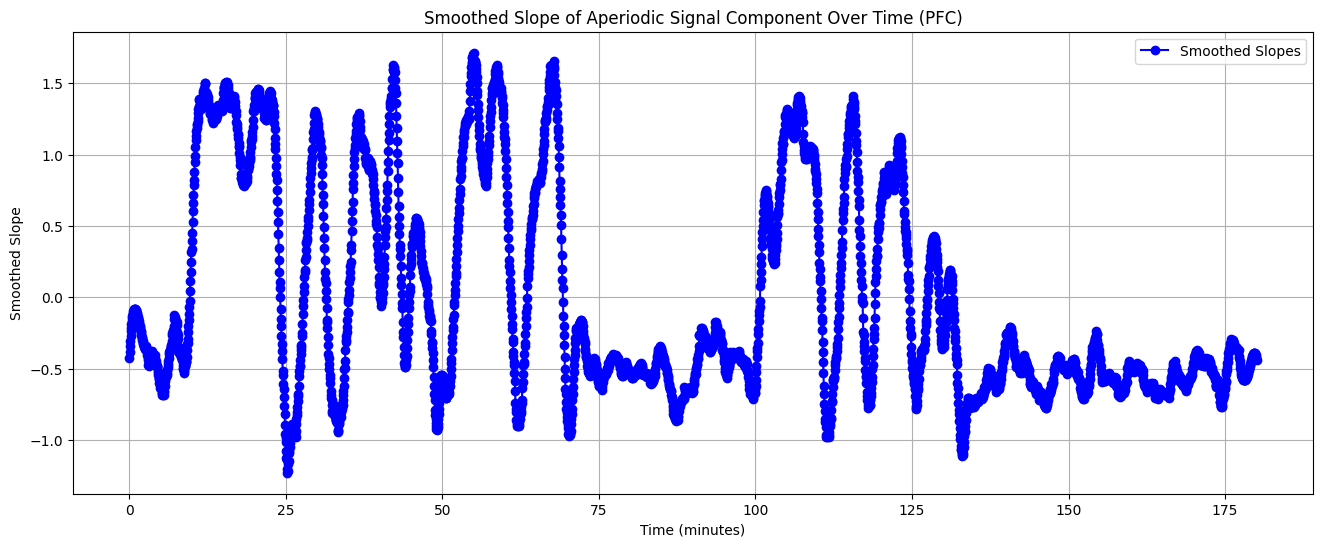

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_minutes, slopes_smoothed_PFC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()
plt.show()

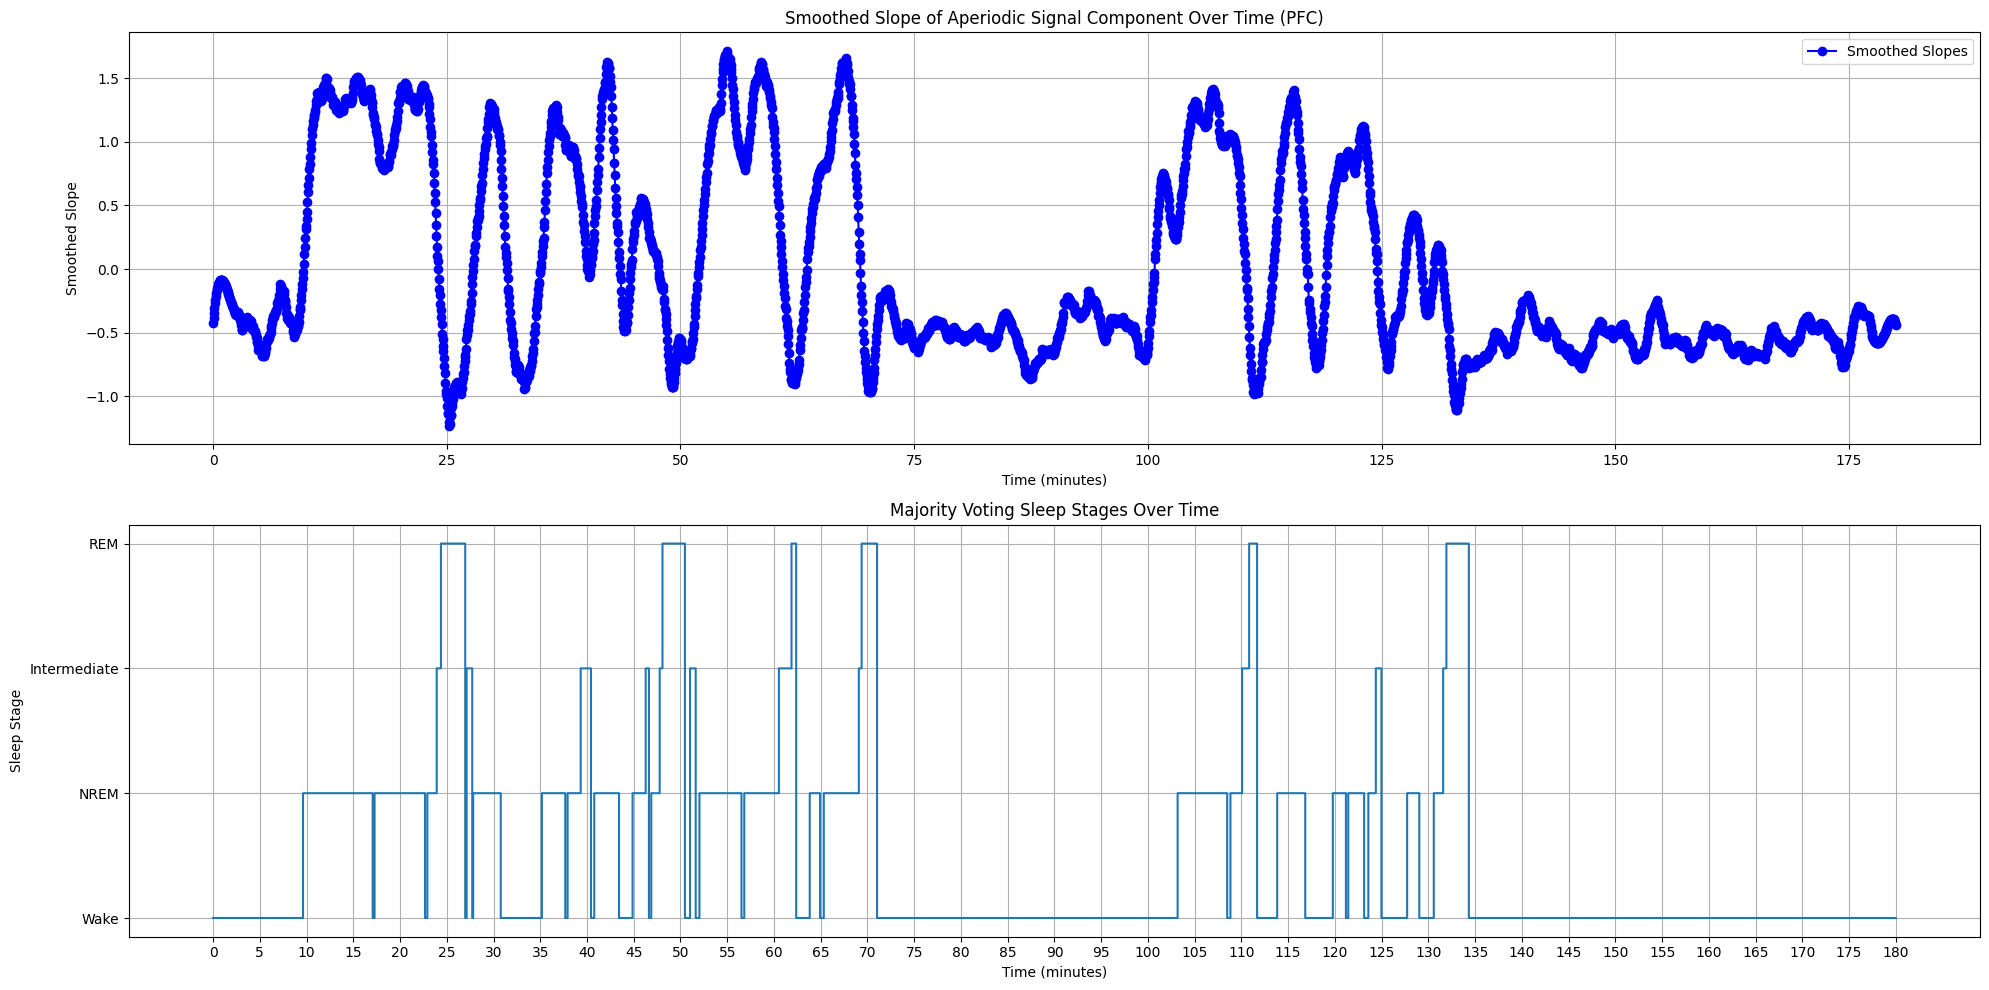

In [ ]:
score_labels = {1: 'Wake', 3: 'NREM', 4: 'Intermediate', 5: 'REM'}
num_labels = {label: num for num, label in enumerate(score_labels.values(), start=1)}

reshaped_scores = sleep_scoring.reshape(-1, 3)
majority_scores = mode(reshaped_scores, axis=1).mode.flatten()

assert all(score in score_labels for score in majority_scores), "Some scores are not in score_labels"

mapped_scores = np.array([num_labels[score_labels[score]] for score in majority_scores])

time_minutes = np.arange(0, len(slopes_smoothed_PFC)) * 3 / 60  # Convert to minutes
sleep_time_minutes = np.arange(0, len(majority_scores)) * 3 / 60  # Convert to minutes

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(time_minutes, slopes_smoothed_PFC, marker='o', linestyle='-', color='blue', label='Smoothed Slopes')
plt.title("Smoothed Slope of Aperiodic Signal Component Over Time (PFC)")
plt.xlabel("Time (minutes)")
plt.ylabel("Smoothed Slope")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.step(sleep_time_minutes, mapped_scores, where='mid')
plt.xlabel('Time (minutes)')
plt.ylabel('Sleep Stage')
plt.title('Majority Voting Sleep Stages Over Time')
plt.yticks(list(num_labels.values()), list(score_labels.values()))
plt.xticks(np.arange(0, max(sleep_time_minutes) + 1, 5))
plt.grid(True)

plt.tight_layout()
plt.show()

# Correlation Between PFC and HPC results

In [ ]:
correlation_coefficient, p_value = pearsonr(slopes_smoothed_HPC, slopes_smoothed_PFC)

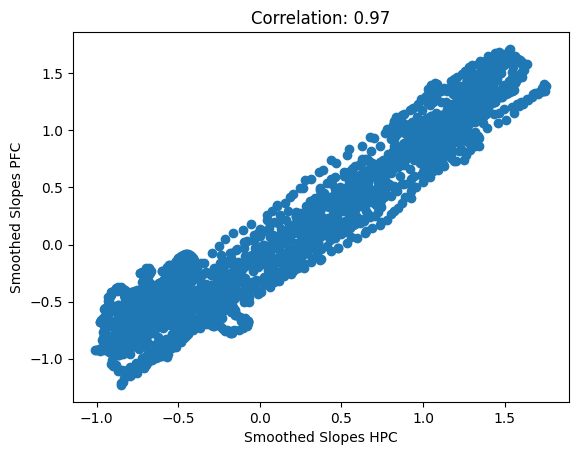

In [ ]:
plt.scatter(slopes_smoothed_HPC, slopes_smoothed_PFC)
plt.xlabel('Smoothed Slopes HPC')
plt.ylabel('Smoothed Slopes PFC')
plt.title(f'Correlation: {correlation_coefficient:.2f}')
plt.show()

# Power of samples

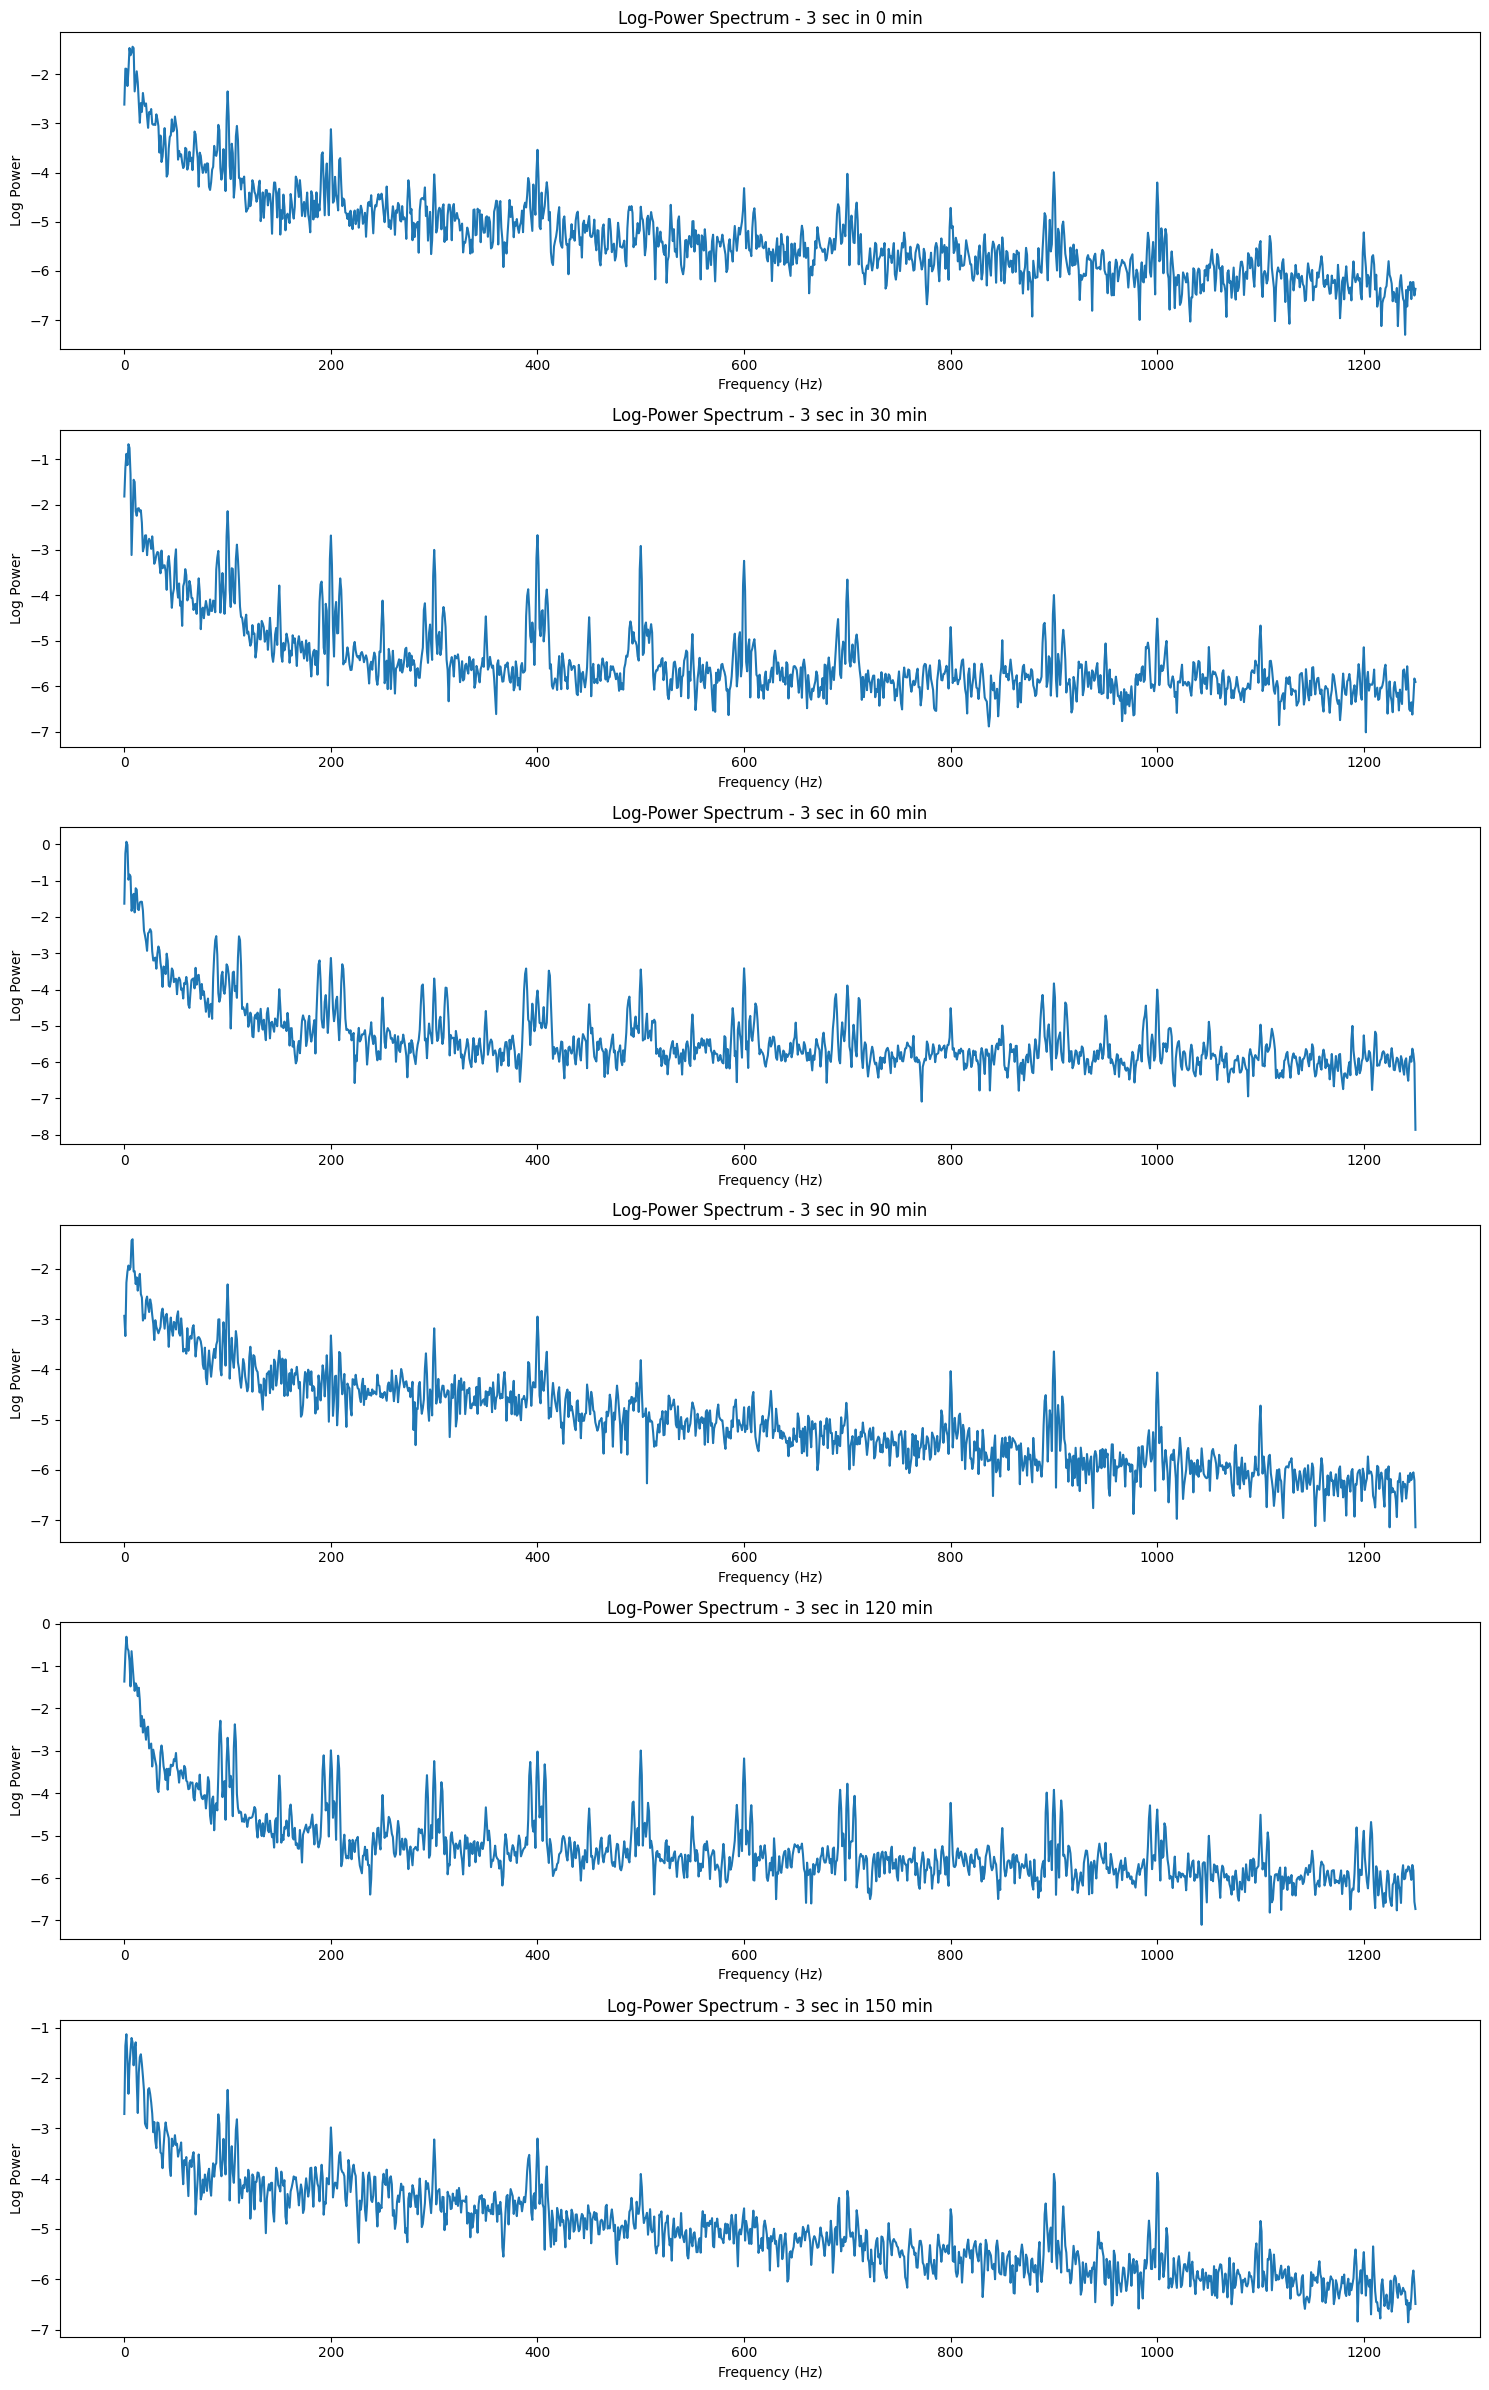

In [ ]:
# Plotting the log-power spectrum for 3-second segments taken every 30 minutes from the signal data.

samples_per_30min = 30 * 60 * fs
samples_per_3sec = 3 * fs

total_samples = sig.shape[0]
num_segments = total_samples // samples_per_30min

plt.figure(figsize=(15, num_segments * 4))

for i in range(num_segments):

    start = i * samples_per_30min
    end = start + samples_per_3sec
    segment_data = sig[start:end]

    freq_mean, psd_mean = compute_spectrum(segment_data, fs, method='welch', nperseg=min(2500, len(segment_data)))

    log_psd = np.log10(psd_mean)

    ax = plt.subplot(num_segments, 1, i + 1)
    ax.plot(freq_mean, log_psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Log Power')
    plt.title(f'Log-Power Spectrum - 3 sec in {i * 30} min')

plt.tight_layout()
plt.show()